In [1]:
!pip install mysql-connector-python
!pip install price_parser
!pip install forex_python
!pip install statsmodels
!pip install cpi

In [43]:
import mysql.connector
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.stattools as tsa
from ast import literal_eval

import price_parser #to handle currencies
import forex_python.converter as converter #to handle currency exchanges
import cpi #to handle inflation
#cpi.update()

# I. Preprocessing

## 1.1 Fetch data from original dataset

### Movies

In [3]:
COLUMNS_NAMES_MOVIES = [
    "freebase_id",
    "movie_name",
    "movie_release_date",
    "freebase_box_office_revenue",
    "freebase_runtime",
    "freebase_languages",
    "freebase_countries",
    "freebase_genres"
]

MOVIE_DATA = pd.read_csv('data/movie.metadata.tsv', sep='\t', header=None, names=COLUMNS_NAMES_MOVIES, index_col=0)
MOVIE_DATA.drop(columns=["freebase_id"], inplace = True)
MOVIE_DATA = MOVIE_DATA.replace('NULL', np.NaN)
MOVIE_DATA["movie_release_date"] = pd.to_datetime(MOVIE_DATA["movie_release_date"], errors="coerce")
MOVIE_DATA["movie_release_year"] = MOVIE_DATA["movie_release_date"].dt.year.astype(int, errors="ignore")
MOVIE_DATA.dropna(subset=["movie_release_year"], inplace=True)

MOVIE_DATA.head()

,movie_name,movie_release_date,freebase_box_office_revenue,freebase_runtime,freebase_languages,freebase_countries,freebase_genres,movie_release_year
975900,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0
3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000.0
28463795,Brun bitter,1988-01-01,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988.0
9363483,White Of The Eye,1987-01-01,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987.0
261236,A Woman in Flames,1983-01-01,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983.0


### Characters

In [4]:
COLUMNS_NAMES_CHARACTERS = [
    "wiki_movie_id",
    "freebase_movie_id",
    "movie_release_date",
    "character_name",
    "actor_date_of_birth",
    "actor_gender",
    "actor_height",
    "actor_ethnicity",
    "actor_name",
    "actor_age_at_movie_release",
    "freebase_character_actor_map_id",
    "freebase_character_id",
    "freebase_actor_id"
]

CHARACTER_DATA = pd.read_csv('data/character.metadata.tsv', sep='\t', header=None, names=COLUMNS_NAMES_CHARACTERS)
CHARACTER_DATA.drop(columns=["freebase_movie_id", "movie_release_date"], inplace = True)
CHARACTER_DATA.dropna(subset=["wiki_movie_id", "character_name"], inplace=True)
CHARACTER_DATA["actor_date_of_birth"] = pd.to_datetime(CHARACTER_DATA["actor_date_of_birth"], errors="coerce")

CHARACTER_DATA.head()

,wiki_movie_id,character_name,actor_date_of_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id
0,975900,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


### Plots

In [5]:
COLUMNS_NAMES_PLOTS = ["wiki_plot"]

PLOT_DATA = pd.read_csv('data/plot_summaries.txt', sep='\t', header=None, names=COLUMNS_NAMES_PLOTS, index_col=0)

PLOT_DATA.head()

,wiki_plot
23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
31186339,The nation of Panem consists of a wealthy Capi...
20663735,Poovalli Induchoodan is sentenced for six yea...
2231378,"The Lemon Drop Kid , a New York City swindler,..."
595909,Seventh-day Adventist Church pastor Michael Ch...


### Tropes

In [6]:
COLUMNS_NAMES_TROPES = [
    "character_type",
    "object"
]

TROPES_DATA = pd.read_csv("data/tvtropes.clusters.txt", sep='\t', header=None, names=COLUMNS_NAMES_TROPES)
TROPES_DATA["character_name"] = TROPES_DATA.apply(lambda x: eval(x["object"])["char"], axis=1)
TROPES_DATA["movie_name"] = TROPES_DATA.apply(lambda x: eval(x["object"])["movie"], axis=1)
TROPES_DATA["freebase_id"] = TROPES_DATA.apply(lambda x: eval(x["object"])["id"], axis=1)
TROPES_DATA["actor_name"] = TROPES_DATA.apply(lambda x: eval(x["object"])["actor"], axis=1)
TROPES_DATA.drop(columns=["object"], axis=1, inplace=True)

TROPES_DATA.head()

,character_type,character_name,movie_name,freebase_id,actor_name
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader


## 1.2 Fetch data scraped from IMDB

In [7]:
db = mysql.connector.connect(
  host ="mysql.micro-ondes.ch",
  user ="r4d4r",
  passwd ="1MotDePasse",
  database = "ada_raw_imdb"
)
cursor = db.cursor()
cursor.execute("SELECT * FROM RAW_DATA")
DB_DATA = cursor.fetchall()

In [8]:
DATA_COLUMNS = ["imdb_id", "title", "cast", "imdb_genres", "imdb_runtimes", "imdb_countries", "imdb_languages", "imdb_box_office", "imdb_rating", "imdb_votes", "imdb_plot", "imdb_synopsis"]

DB_DATA = pd.DataFrame(map(lambda x: x[1:], DB_DATA), index=map(lambda x: x[0], DB_DATA), columns=DATA_COLUMNS)
DB_DATA = DB_DATA.replace('NULL', np.NaN)
DB_DATA.drop(columns=["title", "imdb_id", "cast"], inplace = True)

DB_DATA.head()

,imdb_genres,imdb_runtimes,imdb_countries,imdb_languages,imdb_box_office,imdb_rating,imdb_votes,imdb_plot,imdb_synopsis
975900,"['Action', 'Horror', 'Sci-Fi']",['98'],['United States'],['English'],"{'Budget': '$28,000,000 (estimated)', 'Opening...",4.9,55370,"['In 2176, a Martian police unit is sent to pi...","[""200 years in the future, Mars has been colon..."
28463795,"['Crime', 'Drama']",['83'],['Norway'],['Norwegian'],NaN,5.7,40,"['The lonely, divorced and disillusioned lawye...",NaN
261236,['Drama'],['106'],['West Germany'],['German'],NaN,6.0,591,"['Eva, an upper-class housewife, frustratingly...",NaN
10408933,"['Drama', 'Music', 'Musical', 'Romance']",['106'],['United States'],['English'],"{'Budget': '$2,000,000 (estimated)'}",6.9,2164,['This send-up of ragtime song and dance begin...,NaN
175026,"['Drama', 'Romance']",['86'],['United States'],['English'],NaN,5.4,274,"[""After years of abusing his wife, a ne'er-do-...",NaN


## 1.3 Merge imdb and freebase

In [9]:
MOVIE_DATA = MOVIE_DATA.join(DB_DATA)

### About box office

#### Parse imdb data

In [10]:
def func(row):
    if pd.isna(row):
        return np.NaN, np.NaN, np.NaN
    imdb_box_office = eval(row)
    budget = imdb_box_office["Budget"] if "Budget" in imdb_box_office.keys() else np.NaN
    cum_world_box_office = imdb_box_office["Cumulative Worldwide Gross"] if "Cumulative Worldwide Gross" in imdb_box_office.keys() else np.NaN
    weekend_US_box_office = imdb_box_office["Opening Weekend United States"] if "Opening Weekend United States" in imdb_box_office.keys() else np.NaN
    return budget, cum_world_box_office, weekend_US_box_office
        
        
MOVIE_DATA["budget"], MOVIE_DATA["cum_world_box_office"], MOVIE_DATA["weekend_US_box_office"] = zip(*MOVIE_DATA["imdb_box_office"].apply(func))            

#### Handle different currencies

In [11]:
def func(val, year):
    if pd.isna(val):
        return np.NaN
    price = price_parser.Price.fromstring(val)
    if price.currency == "$":
        return price.amount_float
    try:
        c = converter.CurrencyRates()
        date = datetime.datetime(int(year), 1, 1, 0, 0)
        return c.get_rate(price.currency, "USD", date) * price.amount_float
    except:
        return np.NaN
    
MOVIE_DATA["budget"] = MOVIE_DATA.apply(lambda x: func(x["budget"], x["movie_release_year"]), axis=1)
MOVIE_DATA["cum_world_box_office"] = MOVIE_DATA.apply(lambda x: func(x["cum_world_box_office"], x["movie_release_year"]), axis=1)
MOVIE_DATA["weekend_US_box_office"] = MOVIE_DATA.apply(lambda x: func(x["weekend_US_box_office"], x["movie_release_year"]), axis=1)

#### Compare IMDB to Freebase

In [12]:
print((np.log(MOVIE_DATA["cum_world_box_office"].dropna())-np.log(MOVIE_DATA["freebase_box_office_revenue"].dropna())).dropna().mean())
print((np.log(MOVIE_DATA["weekend_US_box_office"].dropna())-np.log(MOVIE_DATA["freebase_box_office_revenue"].dropna())).dropna().mean())

-0.13212905952193935
-2.6568221807037284


/Users/teframartin/opt/anaconda3/envs/py310/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [13]:
MOVIE_DATA["box_office"] = MOVIE_DATA["freebase_box_office_revenue"]
MOVIE_DATA.drop(columns=["freebase_box_office_revenue", "imdb_box_office", "cum_world_box_office", "weekend_US_box_office"], inplace = True)

#### Handle inflation

In [14]:
def func(val, year):
    try:
        return cpi.inflate(val, int(year))
    except:
        np.NaN
    
MOVIE_DATA["budget_inflated"] = MOVIE_DATA.apply(lambda x: func(x["budget"], x["movie_release_year"]), axis=1)
MOVIE_DATA["box_office_inflated"] = MOVIE_DATA.apply(lambda x: func(x["box_office"], x["movie_release_year"]), axis=1)

### Handle languages

In [15]:
def func(freebase, imdb):
    if isinstance(imdb, str):
        languages = set(eval(imdb))
    else:
        languages = set()
    if freebase:
        freebase = eval(freebase)
        for key, val in freebase.items():
            l = val.replace("Language", "").replace("language", "").strip()
            languages.update([l])
    return languages

MOVIE_DATA["languages"] = MOVIE_DATA.apply(lambda x: func(x["freebase_languages"], x["imdb_languages"]), axis=1)
MOVIE_DATA.drop(columns=["freebase_languages", "imdb_languages"], inplace = True)

### Handle countries

In [16]:
def func(freebase, imdb):
    if isinstance(imdb, str):
        countries = set(eval(imdb))
    else:
        countries = set()
    if freebase:
        freebase = eval(freebase)
        for key, val in freebase.items():
            c = val.replace("of America", "").strip()
            countries.update([c])
    return countries

MOVIE_DATA["countries"] = MOVIE_DATA.apply(lambda x: func(x["freebase_countries"], x["imdb_countries"]), axis=1)
MOVIE_DATA.drop(columns=["freebase_countries", "imdb_countries"], inplace = True)

### Handle genres

In [17]:
def func(freebase, imdb):
    if isinstance(imdb, str):
        genres = set(eval(imdb))
    else:
        genres = set()
    if freebase:
        freebase = eval(freebase)
        for key, val in freebase.items():
            g = val.strip()
            genres.update([g])
    return genres

MOVIE_DATA["genres"] = MOVIE_DATA.apply(lambda x: func(x["freebase_genres"], x["imdb_genres"]), axis=1)
MOVIE_DATA.drop(columns=["freebase_genres", "imdb_genres"], inplace = True)
MOVIE_DATA.drop(MOVIE_DATA[MOVIE_DATA["genres"].map(lambda x: "Short Film" in x)].index, inplace=True)

### Handle runtime

In [18]:
def func(freebase, imdb):
    if not isinstance(imdb, str):
        return freebase if not np.isnan(freebase) else np.NaN
    imdb = eval(imdb)
    if not freebase:
        return float(imdb[0])
    if freebase in imdb:
        return freebase   
    return float(imdb[0])

MOVIE_DATA["runtime"] = MOVIE_DATA.apply(lambda x: func(x["freebase_runtime"], x["imdb_runtimes"]), axis=1)
MOVIE_DATA.drop(columns=["freebase_runtime", "imdb_runtimes"], inplace = True)
MOVIE_DATA[MOVIE_DATA["runtime"] > 360] = np.NaN

### Change column datatypes

In [19]:
def func(val):
    if isinstance(val, str):
        return set(eval(val))
    else:
        return np.NaN

MOVIE_DATA["imdb_plot"] = MOVIE_DATA["imdb_plot"].apply(func)
MOVIE_DATA["imdb_synopsis"] = MOVIE_DATA["imdb_synopsis"].apply(func)

### Add wikipedia plots

In [20]:
MOVIE_DATA = MOVIE_DATA.join(PLOT_DATA, how="left")

### Find main characters

In [21]:
def func(i, imdb_plot, imdb_synopsis, wiki_plot):
    characters = CHARACTER_DATA[CHARACTER_DATA["wiki_movie_id"] == i]
    if characters.shape[0] == 0:
        return []
    bigplot = ""
    if isinstance(imdb_plot, set):
        bigplot = bigplot + " " + " ".join(imdb_plot)
    if isinstance(imdb_synopsis, set):
        bigplot = bigplot + " " + " ".join(imdb_synopsis)
    if isinstance(wiki_plot, str):
        bigplot = bigplot + wiki_plot
    if bigplot == "":
        return []
    bigplot = bigplot.casefold()
    occurences = []
    for c, character in characters.iterrows():
        localcount = 0
        for c_part in character["character_name"].casefold().split():
            localcount += bigplot.count(c_part.strip())
        occurences.append(localcount)
    if max(occurences) == 0:
        return []
    return list(characters.iloc[[idx for idx, val in enumerate(occurences) if val == max(occurences)]]["freebase_character_actor_map_id"])

MOVIE_DATA["main_characters"] = MOVIE_DATA.apply(lambda x: func(x.name, x["imdb_plot"], x["imdb_synopsis"], x["wiki_plot"]), axis=1)

### Add tropes to characters

In [22]:
#CHARACTER_DATA = CHARACTER_DATA.join(TROPES_DATA.set_index(["character_name", "actor_name"]), on=["character_name", "actor_name"])
CHARACTER_DATA.head()

,wiki_movie_id,character_name,actor_date_of_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id
0,975900,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [23]:
TROPES_DATA.head()

,character_type,character_name,movie_name,freebase_id,actor_name
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader


### Rearrange columns

In [24]:
COLUMNS_NAMES_MOVIES = ["movie_name", "movie_release_date", "movie_release_year", "runtime", "imdb_rating", "imdb_votes", "languages", "countries", "genres", "budget", "budget_inflated", "box_office", "box_office_inflated", "imdb_plot", "imdb_synopsis", "wiki_plot", "main_characters"]
MOVIE_DATA = MOVIE_DATA[COLUMNS_NAMES_MOVIES]
MOVIE_DATA.head()

,movie_name,movie_release_date,movie_release_year,runtime,imdb_rating,imdb_votes,languages,countries,genres,budget,budget_inflated,box_office,box_office_inflated,imdb_plot,imdb_synopsis,wiki_plot,main_characters
975900,Ghosts of Mars,2001-08-24,2001.0,98.0,4.9,55370.0,{English},{United States},"{Space western, Action, Adventure, Science Fic...",28000000.0,4.284111e+07,14010832.0,2.143713e+07,"{Set 200 years in the future, intergalactic co...","{200 years in the future, Mars has been coloni...","Set in the second half of the 22nd century, th...",[/m/0jys3m]
3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,2000.0,95.0,NaN,NaN,{English},{United States},"{Mystery, Biographical film, Crime Drama, Drama}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
28463795,Brun bitter,1988-01-01,1988.0,83.0,5.7,40.0,{Norwegian},{Norway},"{Crime, Crime Fiction, Drama}",NaN,NaN,NaN,NaN,"{The lonely, divorced and disillusioned lawyer...",NaN,NaN,[]
9363483,White Of The Eye,1987-01-01,1987.0,110.0,NaN,NaN,{English},{United Kingdom},"{Psychological thriller, Thriller, Erotic thri...",NaN,NaN,NaN,NaN,NaN,NaN,A series of murders of rich young women throug...,[]
261236,A Woman in Flames,1983-01-01,1983.0,106.0,6.0,591.0,{German},"{West Germany, Germany}",{Drama},NaN,NaN,NaN,NaN,"{Eva, an upper-class housewife, frustratingly ...",NaN,"Eva, an upper class housewife, becomes frustra...",[]


## 1.4 Dump to csv

In [26]:
MOVIE_DATA["genres"] = MOVIE_DATA.genres.apply(lambda x: list(x) if isinstance(x, set) else [])
MOVIE_DATA["languages"] = MOVIE_DATA.languages.apply(lambda x: list(x) if isinstance(x, set) else [])
MOVIE_DATA["countries"] = MOVIE_DATA.countries.apply(lambda x: list(x) if isinstance(x, set) else [])

In [27]:
#Export joined and cleaned data to csv
MOVIE_DATA.to_csv("data/movie_processed.csv")

/Users/teframartin/opt/anaconda3/envs/py310/lib/python3.10/site-packages/pandas/core/internals/blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


# II. Insights of the data

In [28]:
df_movies = pd.read_csv("data/movie_processed.csv", index_col=0)

### 2.1 Movie production evolution

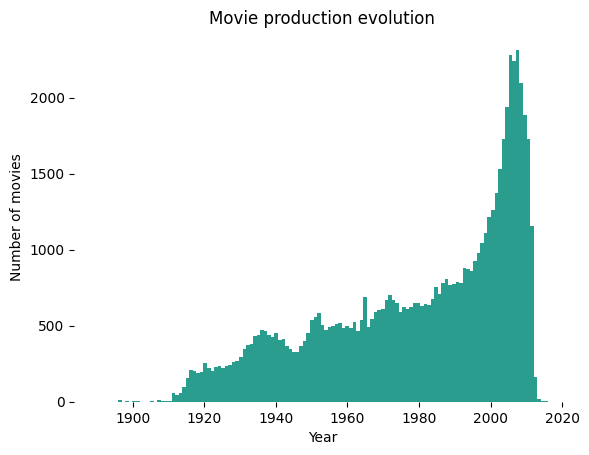

In [30]:
fig, ax = plt.subplots()

ax.hist(df_movies["movie_release_year"], bins=int(max(df_movies["movie_release_year"]) - min(df_movies["movie_release_year"]) + 1), color="#2a9d8f")
ax.set_xlabel("Year")
ax.set_ylabel("Number of movies")
ax.set_title("Movie production evolution")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()

###  2.2 Number of movies per country

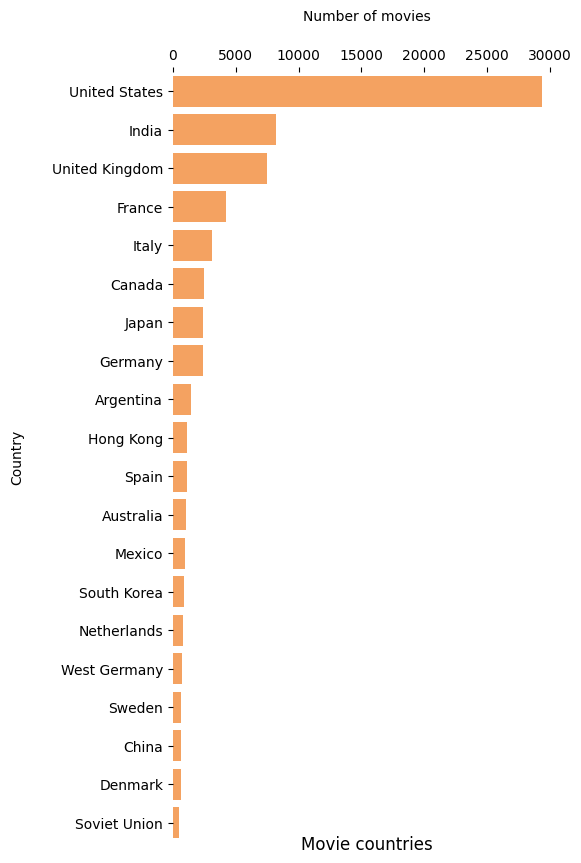

In [45]:
country_data = df_movies["countries"].apply(literal_eval).explode().value_counts()[:20].sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(5,10))
ax.barh(country_data.index, np.array(country_data.values), color="#f4a261")
ax.set_ylabel("Country")
ax.set_xlabel("Number of movies")
ax.set_title("Movie countries", y = -0.02)
plt.ylim([-0.5,country_data.size-0.5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

plt.show()

The plot of the number of movies depending of their country of origin shows clearly that the USA dominates the movie industry. The rest of the world is far behind. The second country is India, followed by UK and France.

In [46]:
prop_usa_prod_global = country_data["United States"] / country_data.sum()
prop_usa_prod_second = country_data["United States"] / country_data["India"]

print("Proportion of movies produced in the USA: {:.2f}%".format(prop_usa_prod_global * 100))
print("The USA procuduces {:.2f} times more movies than India, the second movie productucor.".format(prop_usa_prod_second))

Proportion of movies produced in the USA: 41.91%
The USA procuduces 3.58 times more movies than India, the second movie productucor.


### 2.3 Number of movies per language

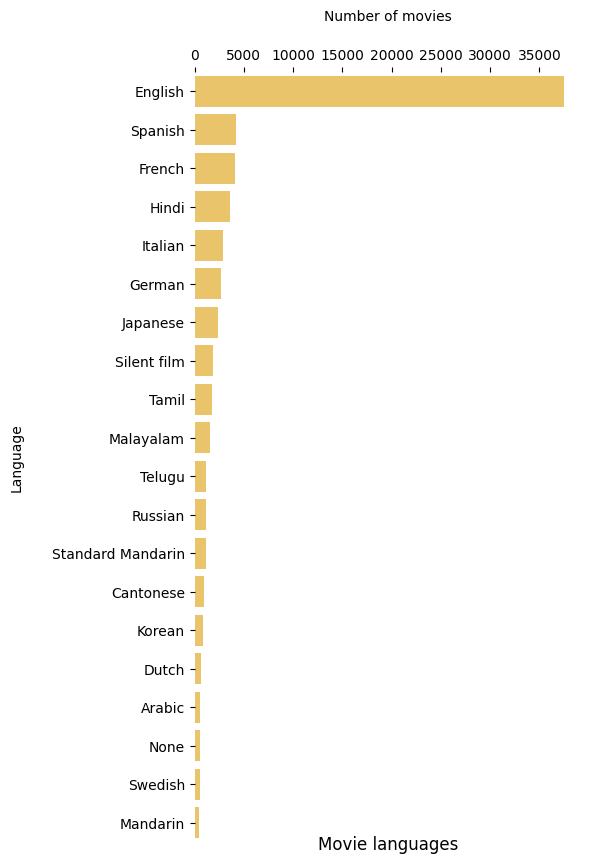

In [47]:
language_data = df_movies["languages"].apply(literal_eval).explode().value_counts()[:20].sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(5,10))
ax.barh(language_data.index, np.array(language_data.values), color="#e9c46a")
ax.set_ylabel("Language")
ax.set_xlabel("Number of movies")
ax.set_title("Movie languages", y = -0.02)
plt.ylim([-0.5, language_data.size-0.5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

plt.show()

This plot shows that the most common languages are English, French, Spanish, German and Italian, english being by far the most common language.

In [48]:
prop_english_movies_global = language_data["English"] / language_data.sum()
prop_english_movies_second = language_data["English"] / language_data["Spanish"]

print("Proportion of movies in English: {:.2f}%".format(prop_english_movies_global * 100))
print("The English language is used in {:.2f} times more movies than Spanish, the second most used language.".format(prop_english_movies_second))

Proportion of movies in English: 53.26%
The English language is used in 8.89 times more movies than Spanish, the second most used language.


### 2.4 Number of movies per genre

In [60]:
genre_data = df_movies["genres"].apply(literal_eval).explode().value_counts()[:20]

#Merge "Romantic Film" and "Romance" genres
genre_data["Romance"] += genre_data["Romance Film"]
genre_data = genre_data.drop("Romance Film")

#Split Action/Adventure
genre_data["Action"] += genre_data["Action/Adventure"]
genre_data["Adventure"] += genre_data["Action/Adventure"]
genre_data = genre_data.drop("Action/Adventure")

genre_data = genre_data.sort_values(ascending=True)

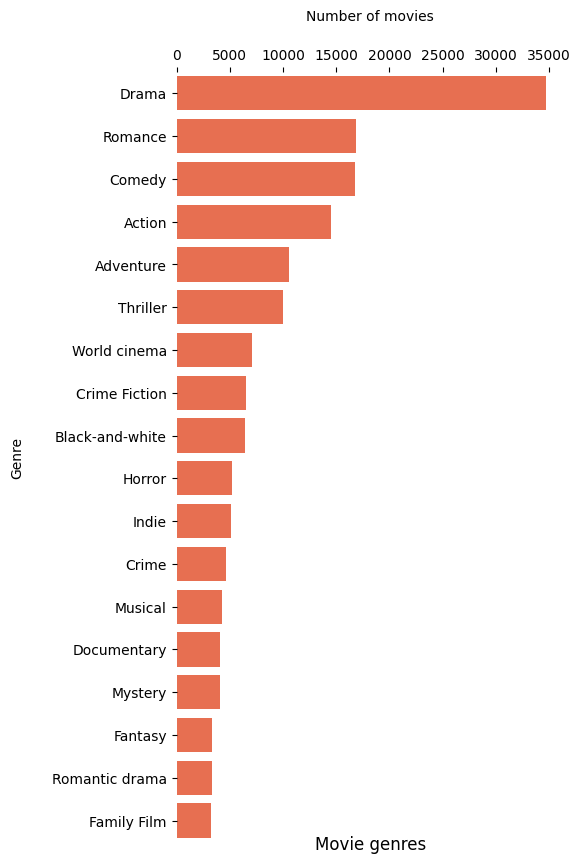

In [61]:
fig, ax = plt.subplots(figsize=(5,10))
ax.barh(genre_data.index, np.array(genre_data.values), color="#e76f51")
ax.set_ylabel("Genre")
ax.set_xlabel("Number of movies")
ax.set_title("Movie genres", y = -0.02)
plt.ylim([-0.5, genre_data.size-0.5])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

plt.show()

In [63]:
prop_main_genre_global = (genre_data["Drama"] + genre_data["Romance"] + genre_data["Comedy"] + genre_data["Action"] + genre_data["Adventure"] + genre_data["Thriller"]) / genre_data.sum()

print("Proportion of movies in the main genres: {:.2f}%".format(prop_main_genre_global * 100))

Proportion of movies in the main genres: 64.30%


This plot shows that the most common genres are Drama, Romance, Comedy, Action, Adventure and Thriller.
Those 6 genres represent almost two thirds of the movies in the dataset.

# III. Analysis of movie production evolution

## Runtime analysis

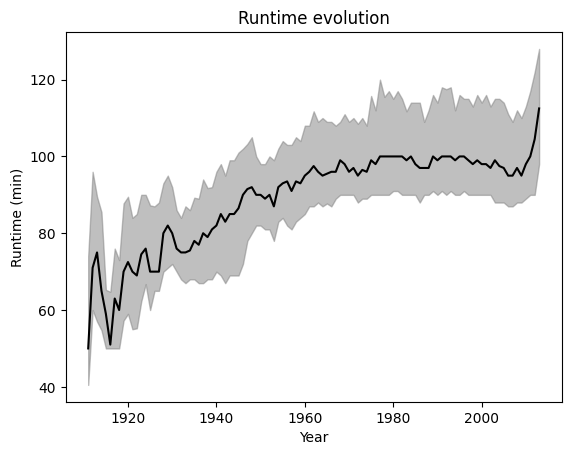

In [ ]:
df_runtime = MOVIE_DATA[["movie_release_year", "runtime"]]
des_runtime = df_runtime.groupby("movie_release_year").describe()["runtime"]
des_runtime = des_runtime[des_runtime["count"] >= 5]
plt.fill_between(des_runtime.index, des_runtime["25%"].values, des_runtime["75%"].values, alpha = 0.5, color = 'gray')
plt.plot(des_runtime.index, des_runtime["50%"], color = 'black')
plt.xlabel('Year')
plt.ylabel('Runtime (min)')
plt.title('Runtime evolution')
plt.show()

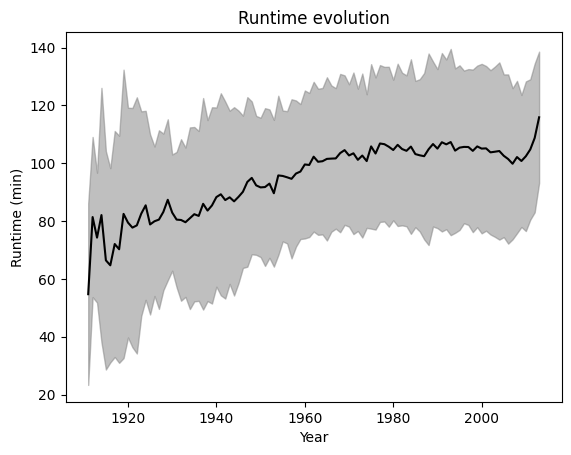

In [ ]:
plt.fill_between(des_runtime.index, des_runtime["mean"].values - des_runtime["std"].values, des_runtime["mean"].values + des_runtime["std"].values, alpha = 0.5, color = 'gray')
plt.plot(des_runtime["mean"], color = 'black')
plt.xlabel('Year')
plt.ylabel('Runtime (min)')
plt.title('Runtime evolution')
plt.show()

## Genres analysis

In [ ]:
df_genre = []
movie_norm_factor = MOVIE_DATA["movie_release_year"].value_counts()
for year in movie_norm_factor.index:
    row = []
    for genre in genre_data.index:
        matched = MOVIE_DATA[MOVIE_DATA["movie_release_year"] == year]
        matched = matched[matched["genres"].apply(lambda x: genre in x)]
        if len(matched):
            row.append(matched.count()["genres"])
        else:
            row.append(0)
    row = np.asarray(row) / movie_norm_factor[year]
    df_genre.append(row)
df_genre = pd.DataFrame(df_genre, index = movie_norm_factor.index, columns=genre_data.index).sort_index()

<AxesSubplot: >

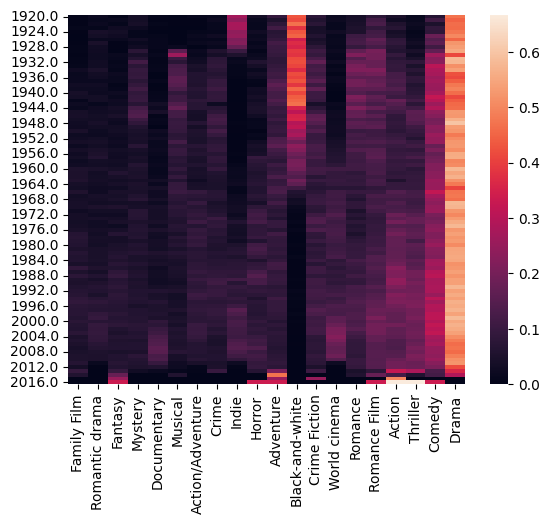

In [ ]:
df_genre_newer = df_genre[df_genre.index > 1919]
sns.heatmap(df_genre_newer)

## Main character analysis

In [ ]:
df_character = MOVIE_DATA[["movie_release_year", "genres", "main_characters"]].explode("main_characters").dropna()

df_character = df_character.join(CHARACTER_DATA.set_index("freebase_character_actor_map_id")[["actor_gender", "actor_height", "actor_age_at_movie_release"]], on="main_characters")
df_character.head()

,movie_release_year,genres,main_characters,actor_gender,actor_height,actor_age_at_movie_release
975900,2001.0,"{Space western, Sci-Fi, Adventure, Supernatura...",/m/0jys3m,F,1.780,27.0
18998739,2002.0,"{Family Film, Fantasy, World cinema, Adventure}",/m/04lrj09,F,1.727,41.0
10408933,1938.0,"{Black-and-white, Comedy, Drama, Musical, Roma...",/m/02vbvj2,M,1.820,24.0
6631279,1997.0,"{Romance Film, Romantic comedy, Romantic drama...",/m/04hvbft,F,1.570,37.0
171005,1989.0,"{War film, Epic, War, History, Costume drama, ...",/m/02vdfck,M,1.830,15.0


### Gender fraction

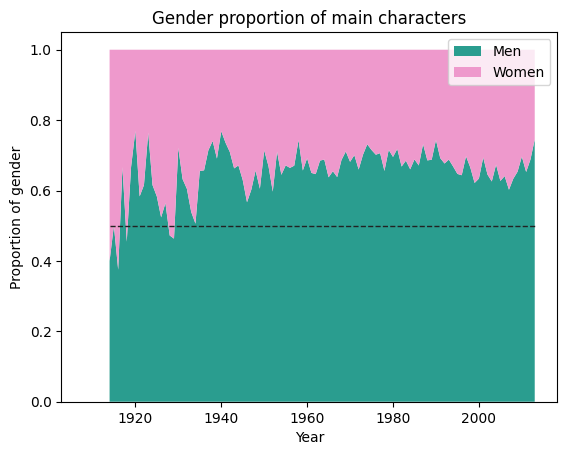

In [ ]:
df_character_F = df_character[df_character["actor_gender"] == "F"]["movie_release_year"].value_counts().sort_index()
df_character_M = df_character[df_character["actor_gender"] == "M"]["movie_release_year"].value_counts().sort_index()

df_character_F = df_character_F[df_character_F.index]
df_character_M = df_character_M[df_character_M.index]

df_sum = df_character_F + df_character_M
df_character_F = df_character_F[df_sum > 0] / df_sum
df_character_M = df_character_M[df_sum > 0] / df_sum

index = df_character_F.index

fig, ax = plt.subplots()
ax.stackplot(df_character_M.index, df_character_M.values, df_character_F.values, colors=["#2a9d8f", "#e9c"], labels=["Men", "Women"])
ax.hlines(y=0.5, xmin=1914, xmax=2013, linewidth=1, color='#222', linestyles='dashed')
ax.set_xlabel("Year")
ax.set_ylabel("Proportion of gender")
ax.set_title("Gender proportion of main characters")
ax.legend()
plt.show()

### Age by gender

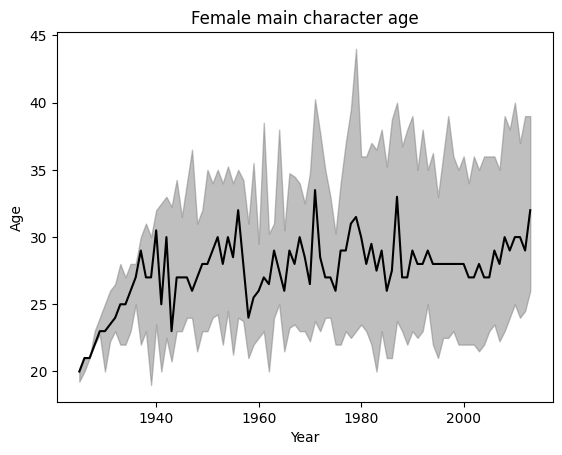

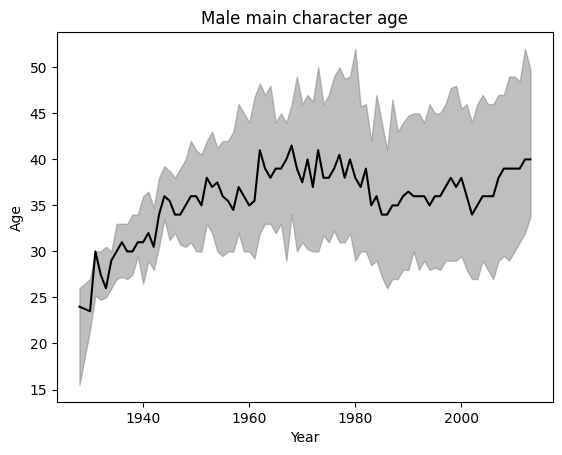

In [ ]:
df_character_F_age = df_character[df_character["actor_gender"] == "F"][["movie_release_year", "actor_age_at_movie_release"]].groupby("movie_release_year").describe()["actor_age_at_movie_release"]
df_character_M_age = df_character[df_character["actor_gender"] == "M"][["movie_release_year", "actor_age_at_movie_release"]].groupby("movie_release_year").describe()["actor_age_at_movie_release"]
df_character_F_age = df_character_F_age[df_character_F_age["count"] >= 5]
df_character_M_age = df_character_M_age[df_character_M_age["count"] >= 5]

plt.fill_between(df_character_F_age.index, df_character_F_age["25%"].values, df_character_F_age["75%"].values, alpha = 0.5, color = 'gray')
plt.plot(df_character_F_age.index, df_character_F_age["50%"].values, color = 'black')
plt.xlabel('Year')
plt.ylabel('Age')
plt.title('Female main character age')
plt.show()

plt.fill_between(df_character_M_age.index, df_character_M_age["25%"].values, df_character_M_age["75%"].values, alpha = 0.5, color = 'gray')
plt.plot(df_character_M_age.index, df_character_M_age["50%"].values, color = 'black')
plt.xlabel('Year')
plt.ylabel('Age')
plt.title('Male main character age')
plt.show()

### Height by gender

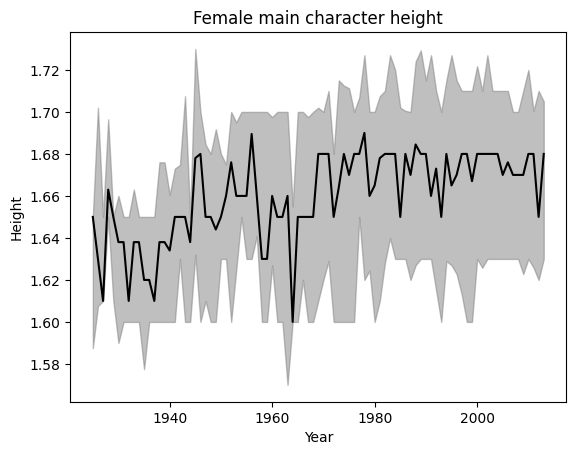

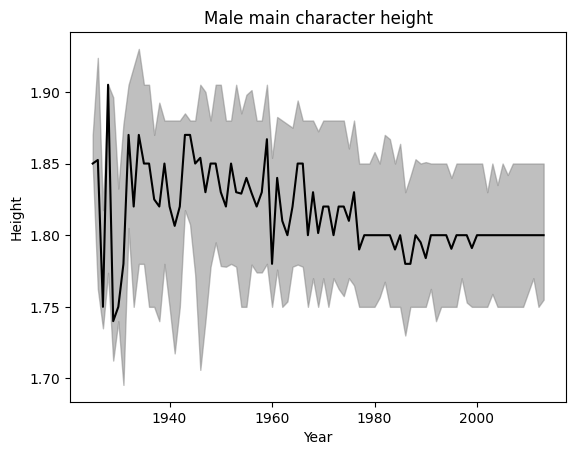

In [ ]:
df_character_F_height = df_character[df_character["actor_gender"] == "F"][["movie_release_year", "actor_height"]].groupby("movie_release_year").describe()["actor_height"]
df_character_M_height = df_character[df_character["actor_gender"] == "M"][["movie_release_year", "actor_height"]].groupby("movie_release_year").describe()["actor_height"]
df_character_F_height = df_character_F_height[df_character_F_height["count"] >= 5]
df_character_M_height = df_character_M_height[df_character_M_height["count"] >= 5]

plt.fill_between(df_character_F_height.index, df_character_F_height["25%"].values, df_character_F_height["75%"].values, alpha = 0.5, color = 'gray')
plt.plot(df_character_F_height.index, df_character_F_height["50%"].values, color = 'black')
plt.xlabel('Year')
plt.ylabel('Height')
plt.title('Female main character height')
plt.show()

plt.fill_between(df_character_M_height.index, df_character_M_height["25%"].values, df_character_M_height["75%"].values, alpha = 0.5, color = 'gray')
plt.plot(df_character_M_height.index, df_character_M_height["50%"].values, color = 'black')
plt.xlabel('Year')
plt.ylabel('Height')
plt.title('Male main character height')
plt.show()

### Gender fraction by genre

In [ ]:
#todo

# What about the box office

In [ ]:
df_box_office = MOVIE_DATA[["movie_release_year", "budget", "budget_inflated", "box_office", "box_office_inflated"]]
des_box_office = df_box_office.groupby("movie_release_year").describe()

In [ ]:
# Helper function to format the axes tick labels
def currency(x, pos):
    if x >= 1e9:
        s = '${:1.0f}B'.format(x*1e-9)
    elif x >= 1e6:
        s = '${:1.0f}M'.format(x*1e-6)
    elif x > 0:
        s = '${:1.0f}K'.format(x*1e-3)
    else:
        s = '${:1.0f}'.format(x)
    return s

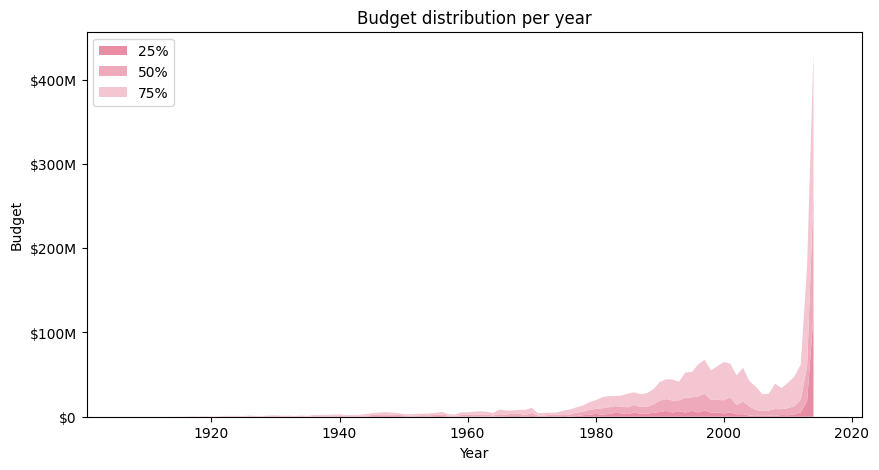

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.stackplot(des_box_office.index, des_box_office["budget"]["25%"], des_box_office["budget"]["50%"], des_box_office["budget"]["75%"], labels=["25%", "50%", "75%"], colors=["#E88DA4", "#EEAABB", "#F3C6D1"])
ax.set_title("Budget distribution per year")
ax.set_xlabel("Year")
ax.set_ylabel("Budget")
ax.legend(loc='upper left')
ax.yaxis.set_major_formatter(currency)
plt.show()

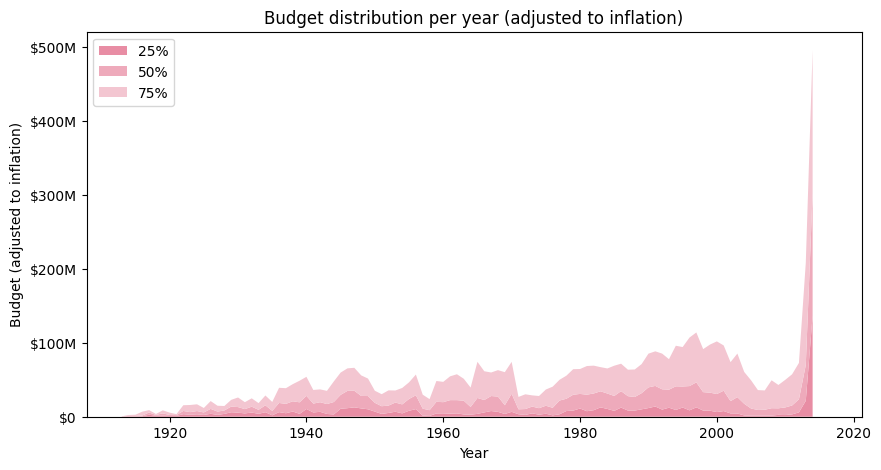

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.stackplot(des_box_office.index, des_box_office["budget_inflated"]["25%"], des_box_office["budget_inflated"]["50%"], des_box_office["budget_inflated"]["75%"], labels=["25%", "50%", "75%"], colors=["#E88DA4", "#EEAABB", "#F3C6D1"])
ax.set_title("Budget distribution per year (adjusted to inflation)")
ax.set_xlabel("Year")
ax.set_ylabel("Budget (adjusted to inflation)")
ax.legend(loc='upper left')
ax.yaxis.set_major_formatter(currency)
plt.show()

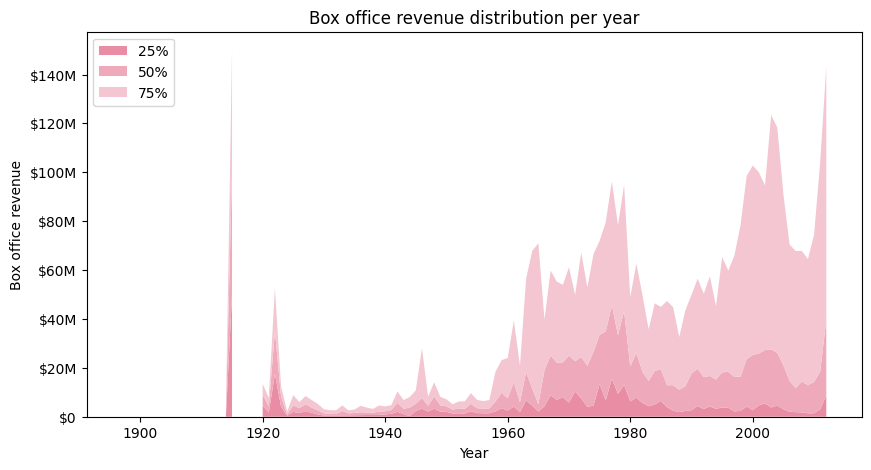

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.stackplot(des_box_office.index, des_box_office["box_office"]["25%"], des_box_office["box_office"]["50%"], des_box_office["box_office"]["75%"], labels=["25%", "50%", "75%"], colors=["#E88DA4", "#EEAABB", "#F3C6D1"])
ax.set_title("Box office revenue distribution per year")
ax.set_xlabel("Year")
ax.set_ylabel("Box office revenue")
ax.legend(loc='upper left')
ax.yaxis.set_major_formatter(currency)
plt.show()

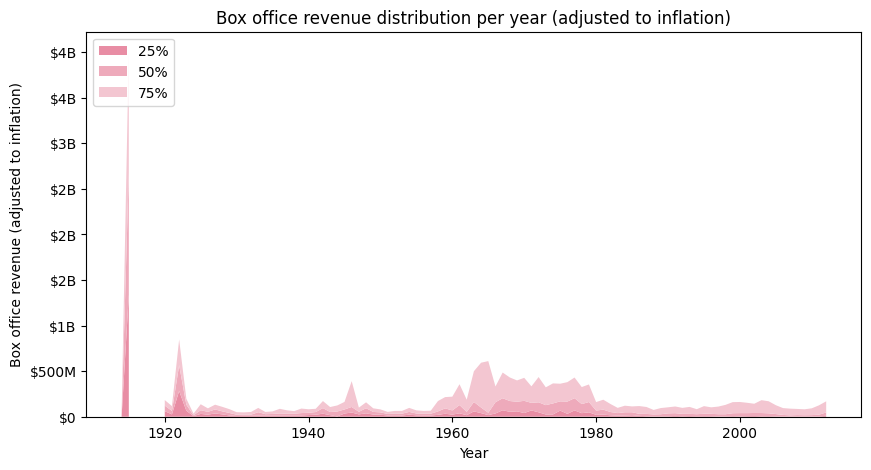

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.stackplot(des_box_office.index, des_box_office["box_office_inflated"]["25%"], des_box_office["box_office_inflated"]["50%"], des_box_office["box_office_inflated"]["75%"], labels=["25%", "50%", "75%"], colors=["#E88DA4", "#EEAABB", "#F3C6D1"])
ax.set_title("Box office revenue distribution per year (adjusted to inflation)")
ax.set_xlabel("Year")
ax.set_ylabel("Box office revenue (adjusted to inflation)")
ax.legend(loc='upper left')
ax.yaxis.set_major_formatter(currency)
plt.show()

# Testing the correlations to box office

In [ ]:
def get_best_causality(results):
    best = (0, 0, 1)
    for lag in results:
        if results[lag][0]['ssr_chi2test'][1] < best[2]:
            best = (lag, *results[lag][0]['ssr_chi2test'][:2])
    return best

### Runtime

In [ ]:
df = pd.concat([des_box_office["box_office_inflated"]["50%"], des_runtime["50%"]], axis=1, join="inner").dropna()
df = df[df.index > 1919]
get_best_causality(tsa.grangercausalitytests(df, maxlag=10, verbose = False))

(3, 7.416925931808278, 0.05973184288007239)

### Genre proportion

In [ ]:
for genre in df_genre:
    df = pd.concat([des_box_office["box_office_inflated"]["50%"], df_genre[genre]], axis=1, join="inner").dropna()
    df = df[df.index > 1919]
    print(genre, get_best_causality(tsa.grangercausalitytests(df, maxlag=10, verbose = False)))

Family Film (6, 8.040712807696705, 0.2351357347233654)
Romantic drama (8, 16.36120818001125, 0.03749242295908729)
Fantasy (4, 18.109158994475063, 0.0011749246099934136)
Mystery (3, 3.5093419389030647, 0.31955252236037035)
Documentary (10, 20.23082872453768, 0.02714349790965297)
Musical (3, 6.476802157415, 0.09058187274442754)
Action/Adventure (3, 9.14922413729206, 0.02737127428824734)
Crime (6, 9.91677414094704, 0.12820087830320753)
Indie (3, 20.483530322904016, 0.00013475076397202127)
Horror (9, 11.212907467574935, 0.2613971264002051)
Adventure (7, 27.207104702237665, 0.0003058491633863187)
Black-and-white (3, 12.198542841492422, 0.00673307853153273)
Crime Fiction (1, 1.5311651877664771, 0.21593765504278245)
World cinema (9, 15.087640014560012, 0.08855661505528688)
Romance (1, 8.459524083922858, 0.0036313686120669495)
Romance Film (1, 11.815219504935287, 0.000587485058041608)
Action (10, 19.15011124427004, 0.038396949579086966)
Thriller (10, 20.55398033655109, 0.024427554352770473)
Co

### Main character gender

In [ ]:
df = pd.concat([des_box_office["box_office_inflated"]["50%"], df_character_F], axis=1, join="inner").dropna()
df = df[df.index > 1919]
get_best_causality(tsa.grangercausalitytests(df, maxlag=10, verbose = False))

(2, 14.377123586109414, 0.00075517443697177)

### Main character age

In [ ]:
df = pd.concat([des_box_office["box_office_inflated"]["50%"], df_character_F_age["50%"]], axis=1, join="inner").dropna()
df = df[df.index > 1919]
get_best_causality(tsa.grangercausalitytests(df, maxlag=10, verbose = False))

(9, 18.23006407555575, 0.03259628591274116)

In [ ]:
df = pd.concat([des_box_office["box_office_inflated"]["50%"], df_character_M_age["50%"]], axis=1, join="inner").dropna()
df = df[df.index > 1919]
get_best_causality(tsa.grangercausalitytests(df, maxlag=10, verbose = False))

(10, 21.627525845853505, 0.017118739418188946)

### Main character height

In [ ]:
df = pd.concat([des_box_office["box_office_inflated"]["50%"], df_character_F_height["50%"]], axis=1, join="inner").dropna()
df = df[df.index > 1919]
get_best_causality(tsa.grangercausalitytests(df, maxlag=10, verbose = False))

(9, 24.18869206172626, 0.004012752375996379)

In [ ]:
df = pd.concat([des_box_office["box_office_inflated"]["50%"], df_character_M_height["50%"]], axis=1, join="inner").dropna()
df = df[df.index > 1919]
get_best_causality(tsa.grangercausalitytests(df, maxlag=10, verbose = False))

(8, 19.70692757601798, 0.011503572599483928)